## 🔍 Comparison of Sampling Methods: Top-k vs Top-p vs Min-p

| Method | How It Works | ✅ Pros | ⚠️ Cons | Typical Use |
|:--|:--|:--|:--|:--|
| **Top-k Sampling** | Selects the *k* highest-probability tokens, normalizes, and samples from them. | • Simple to implement<br>• Stable number of choices<br>• Prevents sampling extreme low-probability tokens | • Ignores distribution shape<br>• Fixed *k* can be too narrow or too wide depending on context entropy | Controlled creativity (e.g., coding, factual Q&A) |
| **Top-p (Nucleus) Sampling** | Selects the smallest set of tokens whose cumulative probability ≥ *p*, then samples. | • Adapts to output uncertainty<br>• Smooth diversity control<br>• Generally higher text quality than Top-k | • Can fluctuate sharply near decision boundary<br>• Sensitive to local probability spikes | Most general-purpose generation (chat, story, code) |
| **Min-p Sampling** | Keeps all tokens with probability ≥ *pₘᵢₙ* (flat threshold), renormalizes, and samples. | • Adapts naturally to entropy<br>• Stable behavior across contexts<br>• Smooth balance between determinism and diversity | • Requires tuning of *pₘᵢₙ* per model<br>• Slightly less interpretable than Top-p | Robust open-ended text generation; modern LLM defaults |

### 🧠 Summary
- **Top-k:** Hard cutoff by rank — stable but rigid.  
- **Top-p:** Adaptive by cumulative probability — flexible but sometimes erratic.  
- **Min-p:** Adaptive by absolute probability — simpler, stable, entropy-aware.  

Use **Min-p** when you want *consistency* and smooth adaptation,  
**Top-p** for balanced creativity, and **Top-k** for tight control.


# Min-p sampling

Keeps all tokens above a certain threshold and samples from them with a multinomial distribution

- Allows a variable number of tokens in distribution
- Adapts to the shape of the distribution produced by the model (if confident, only few tokens sampled, if not, many tokens sampled)
- supposed to be more stable across diverse prompts

Typical threshold `p_min \in [10^-4, 10^-3]`

In [1]:
import torch

def min_p_sample(logits, p_min=1e-4, temperature=1.0):
    probs = torch.softmax(logits / temperature, dim=-1)
    mask = probs >= p_min
    probs = probs * mask
    probs = probs / probs.sum(dim=-1, keepdim=True)
    return torch.multinomial(probs, 1)

# Top-k sampling

Keeps the top-k tokens in the distribution and then normalizes and samples from a multinomial of those tokens (set all non-top-k values to -inf and sample).

In [2]:


def top_k_sample(logits, k=50, temperature=1.0):
    # Apply temperature
    logits = logits / temperature
    # Zero out everything not in top k
    topk = torch.topk(logits, k)
    mask = torch.full_like(logits, float('-inf'))
    mask.scatter_(1, topk.indices, topk.values)
    probs = torch.softmax(mask, dim=-1)
    return torch.multinomial(probs, 1)


# Top p sampling (nucleus)

Keep the total probability mass p of tokens, renormalize, sample

- sort the logits and indicies (descending)
- apply softmax
- compute cumsum
- find cutoff where cumsum > p
- mask everything after the cutoff
- restore original order, use softmax to [0,1.0]

In [3]:
def top_p_sample(logits, p=0.9, temperature=1.0):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probs = torch.softmax(sorted_logits, dim=-1)
    cumulative_probs = torch.cumsum(probs, dim=-1)

    # Find cutoff where cumulative ≥ p
    cutoff = cumulative_probs > p
    # Mask everything beyond the first cutoff
    cutoff[..., 1:] = cutoff[..., :-1].clone()
    cutoff[..., 0] = False
    sorted_logits[cutoff] = float('-inf')

    # Restore original order
    logits_filtered = torch.full_like(logits, float('-inf'))
    logits_filtered.scatter_(1, sorted_indices, sorted_logits)
    probs = torch.softmax(logits_filtered, dim=-1)
    return torch.multinomial(probs, 1)


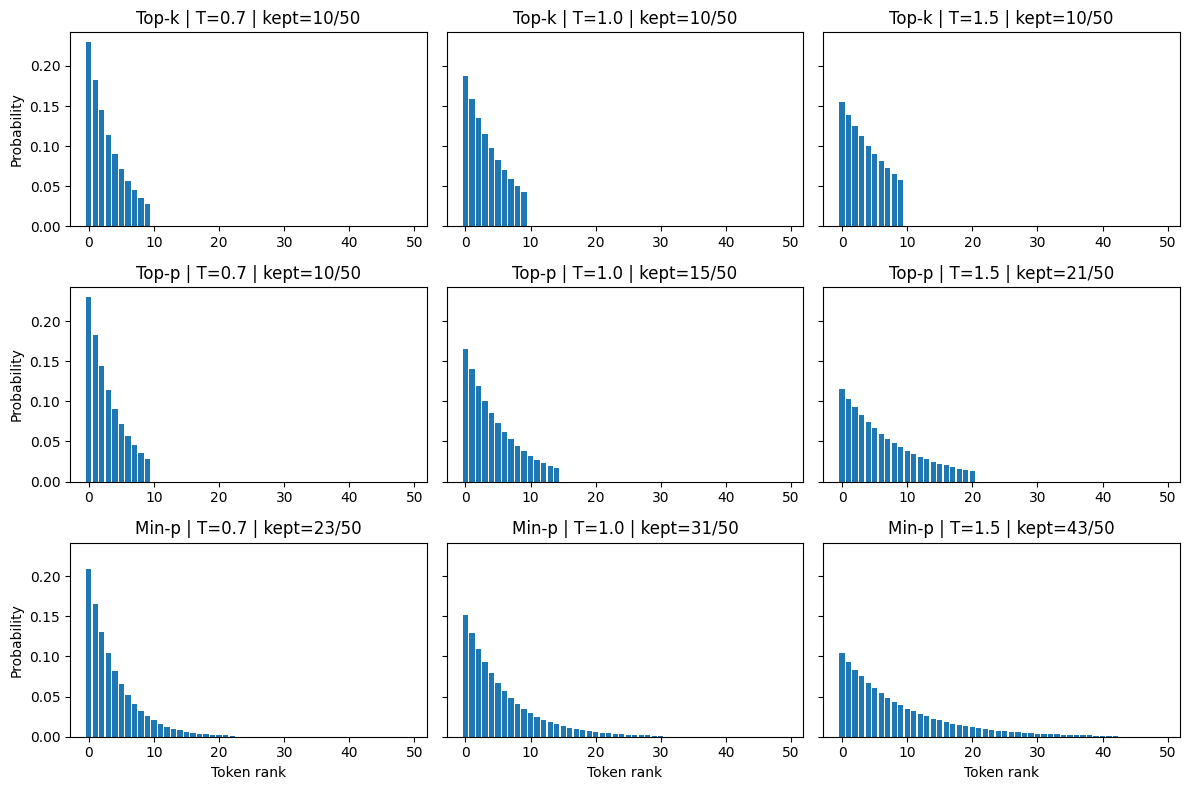

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- original sampling functions (with small tweak to return mask + probs) ---

def top_k_probs(logits, k=50, temperature=1.0):
    logits = logits / temperature
    topk = torch.topk(logits, k)
    mask = torch.full_like(logits, float('-inf'))
    mask.scatter_(1, topk.indices, topk.values)
    probs = torch.softmax(mask, dim=-1)
    return probs, probs > 0  # (normalized probs, selection mask)

def top_p_probs(logits, p=0.9, temperature=1.0):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probs = torch.softmax(sorted_logits, dim=-1)
    cumulative_probs = torch.cumsum(probs, dim=-1)

    cutoff = cumulative_probs > p
    cutoff[..., 1:] = cutoff[..., :-1].clone()
    cutoff[..., 0] = False
    sorted_logits[cutoff] = float('-inf')

    logits_filtered = torch.full_like(logits, float('-inf'))
    logits_filtered.scatter_(1, sorted_indices, sorted_logits)
    probs = torch.softmax(logits_filtered, dim=-1)
    return probs, probs > 0

def min_p_probs(logits, p_min=1e-4, temperature=1.0):
    probs = torch.softmax(logits / temperature, dim=-1)
    mask = probs >= p_min
    probs = probs * mask
    probs = probs / probs.sum(dim=-1, keepdim=True)
    return probs, mask

# --- parameters ---

vocab_size = 50
base_logits = torch.linspace(3, -5, vocab_size).unsqueeze(0)
temperatures = [0.7, 1.0, 1.5]
methods = ["Top-k", "Top-p", "Min-p"]

# hyperparams
k = 10
p = 0.9
p_min = 1e-3

# --- plotting ---

fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharey=True)
x = np.arange(vocab_size)

for i, method in enumerate(methods):
    for j, T in enumerate(temperatures):
        if method == "Top-k":
            probs, mask = top_k_probs(base_logits, k=k, temperature=T)
        elif method == "Top-p":
            probs, mask = top_p_probs(base_logits, p=p, temperature=T)
        else:
            probs, mask = min_p_probs(base_logits, p_min=p_min, temperature=T)

        probs = probs.squeeze(0).numpy()
        mask = mask.squeeze(0).numpy()

        ax = axes[i, j]
        ax.bar(x, probs, color=np.where(mask, "C0", "lightgray"))
        kept = mask.sum()
        ax.set_title(f"{method} | T={T} | kept={kept}/{vocab_size}")
        if j == 0:
            ax.set_ylabel("Probability")
        if i == 2:
            ax.set_xlabel("Token rank")

plt.tight_layout()
plt.show()


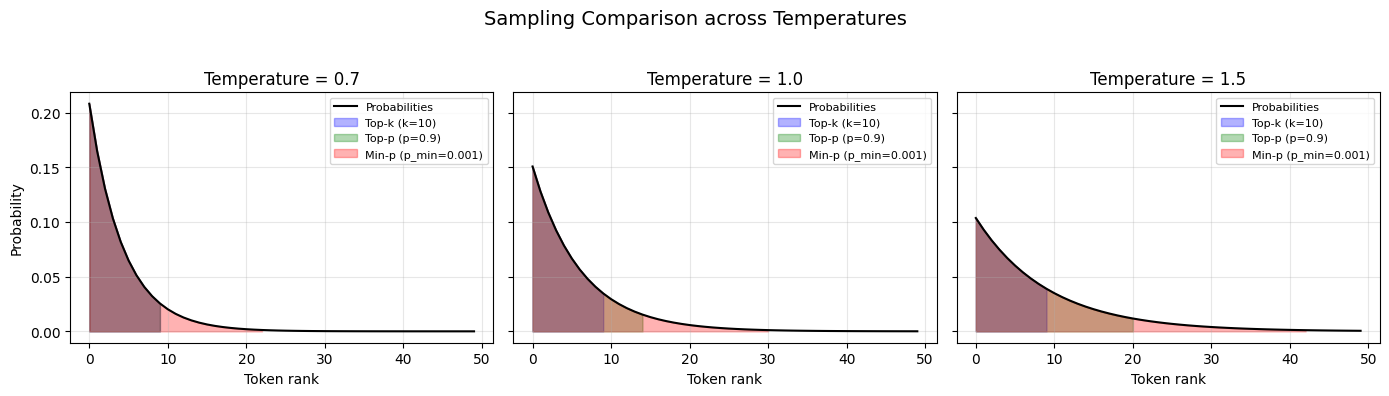

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- sampling variants returning masks/probs (from your versions) ---

def top_k_probs(logits, k=50, temperature=1.0):
    logits = logits / temperature
    topk = torch.topk(logits, k)
    mask = torch.full_like(logits, float('-inf'))
    mask.scatter_(1, topk.indices, topk.values)
    probs = torch.softmax(mask, dim=-1)
    return probs, probs > 0

def top_p_probs(logits, p=0.9, temperature=1.0):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probs = torch.softmax(sorted_logits, dim=-1)
    cumulative_probs = torch.cumsum(probs, dim=-1)

    cutoff = cumulative_probs > p
    cutoff[..., 1:] = cutoff[..., :-1].clone()
    cutoff[..., 0] = False
    sorted_logits[cutoff] = float('-inf')

    logits_filtered = torch.full_like(logits, float('-inf'))
    logits_filtered.scatter_(1, sorted_indices, sorted_logits)
    probs = torch.softmax(logits_filtered, dim=-1)
    return probs, probs > 0

def min_p_probs(logits, p_min=1e-4, temperature=1.0):
    probs = torch.softmax(logits / temperature, dim=-1)
    mask = probs >= p_min
    probs = probs * mask
    probs = probs / probs.sum(dim=-1, keepdim=True)
    return probs, mask

# --- setup ---

vocab_size = 50
base_logits = torch.linspace(3, -5, vocab_size).unsqueeze(0)
temperatures = [0.7, 1.0, 1.5]
k = 10
p = 0.9
p_min = 1e-3
x = np.arange(vocab_size)

# --- plotting ---

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for j, T in enumerate(temperatures):
    probs_base = torch.softmax(base_logits / T, dim=-1).squeeze(0).numpy()

    # Compute masks
    _, mask_k = top_k_probs(base_logits, k=k, temperature=T)
    _, mask_p = top_p_probs(base_logits, p=p, temperature=T)
    _, mask_min = min_p_probs(base_logits, p_min=p_min, temperature=T)

    mask_k = mask_k.squeeze(0).numpy()
    mask_p = mask_p.squeeze(0).numpy()
    mask_min = mask_min.squeeze(0).numpy()

    ax = axes[j]
    ax.plot(x, probs_base, color='black', lw=1.5, label='Probabilities')

    # Shade selected regions
    ax.fill_between(x, 0, probs_base, where=mask_k, color='blue', alpha=0.3, label=f"Top-k (k={k})")
    ax.fill_between(x, 0, probs_base, where=mask_p, color='green', alpha=0.3, label=f"Top-p (p={p})")
    ax.fill_between(x, 0, probs_base, where=mask_min, color='red', alpha=0.3, label=f"Min-p (p_min={p_min})")

    ax.set_title(f"Temperature = {T}")
    ax.set_xlabel("Token rank")
    if j == 0:
        ax.set_ylabel("Probability")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle("Sampling Comparison across Temperatures", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
